# Pruning

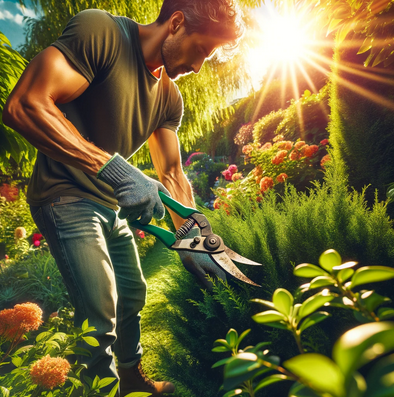

## Wstęp

Deep Learning to dziedzina mocno eksperymentalna, a co za tym idzie, dla danego problemu może istnieć wiele zadowalających rozwiązań (zazwyczaj nieoptymalnych). Często zdarza się, że architektury sieci neuronowych są nieproporcjonalnie duże do stopnia skomplikowania zadania. Okazuje się, że możemy odchudzić modele z tylko niewielką stratą poprawności predykcji.

**Pruning** (przycinanie) sieci polega na usunięciu poszczególnych wag lub całych neuronów. Istnieje wiele zalet tej metody:
- zmniejszenie rozmiaru sieci,
- przyspieszenie inferencji,
- przeciwdziałanie przeuczeniu,
- polepszenie wyników.

Aby skutecznie zmniejszyć rozmiar sieci, musimy wyzerować odpowiednio dużo elementów w jej macierzach wag. Dzięki temu, będziemy w stanie lepiej skompresować model w pamięci. Jednak samo wyzerowanie wag nie wystarczy do przyspieszenia inferencji. Należy dodatkowo zaimplementować i skutecznie wykorzystać liczenie macierzy rzadkich (Sparse Matrix). Inną metodą przycinania może być usuwanie całych neuronów - zmniejszając w ten sposób faktyczny rozmiar macierzy wag.

W tym zadaniu skupimy się **tylko** na **zerowaniu wag** w modelu. **Nie można zmieniać architektury sieci** (np. poprzez usunięcie neuronu lub całej ukrytej warstwy). Rozpatrzymy ten problem na przykładzie **regresji**.

## Zadanie

Zaimplementuj funkcję `your_pruning_algorithm(model : torch.nn.Module) -> pruned_model: torch.nn.Module`, która przyjmie na wejściu zaimplementowany poniżej model i zwróci jego wyczyszczoną wersję - tzn. z jak największą liczbą wyzerowanych parametrów modelu (wag i stałych [weights and biases]), przy zachowaniu jak najniższego średniego błędu kwadratowego (MSE) predykcji.

Poniżej w notatniku znajdziesz komórkę, w której znajduje się miejsce na Twoją funkcję. Komórki, które będziesz miał zmodyfikować będą bardzo jasno oznaczone!

Oceniany będziesz na podstawie wyniku poniższej funkcji (im wyższa wartość tym lepiej):

$$
\mathrm{score}(s, \epsilon) = \begin{cases}
    0 & \text{jeżeli } \epsilon > 1000 \\
    (1 - \frac{\epsilon}{1000})^{1.5} \cdot s ^{1.5} & \text{w.p.p.}
\end{cases}
$$

gdzie:
- $s$ - liczba zerowych parametrów modelu podzielona przez liczbę wszystkich parametrów modelu (sparsity)
- $\epsilon$ - średni błąd kwadratowy na zbiorze testowym (MSE)

To kryterium i wszystkie funkcje, o których mowa powyżej, są zaimplementowane poniżej przez nas.

## Ograniczenia

- Twoja funkcja powinna zwracać model w maksymalnie 5 minut używając Google Colab z GPU.
- Plik z wagami powinien być zapisany funkcją `save_parameters` pod nazwą `model_parameters.pkl`.

- **Nie możesz** zmieniać architektury modelu, tzn. musi on mieć dokładnie:
    - warstwę wejściową o rozmiarze 128
    - warstwę ukrytą o rozmiarze 1024
    - funkcję aktywacji Sigmoid
    - warstwę wyjściową o rozmiarze 10

## Pliki zgłoszeniowe

* Ten notebook
* Parametry (wagi) modelu, zapisane funkcją `save_parameters`. **Nie zmieniaj** nazwy wygenerowanego pliku: `model_parameters.pkl`.

## Ewaluacja

Oceniony zostanie dostarczony przez Ciebie plik z wagami. Powinieneś dostarczyć jednak również działający notebook, który po uruchomieniu wszystkich komórek z flagą `FINAL_EVALUATION_MODE` ustawioną na `True` wyprodukuje plik z wagami `model_parameters.pkl` w czasie poniżej 5 minut (liczonym na google colab z dostępem do GPU). 

# Kod startowy

In [ ]:
FINAL_EVALUATION_MODE = False  # Podczas sprawdzania ustawimy tą dlagę na True.

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import copy
import pickle

import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import SGD


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using {device} device")

## Ładowanie danych

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Funkcja ładująca dane treningowe i walidacyjne jako np.array
def load_data_from_file(x_train_path, y_train_path, x_valid_path, y_valid_path):
    X_train = np.load(x_train_path)
    y_train = np.load(y_train_path)

    X_valid = np.load(x_valid_path)
    y_valid = np.load(y_valid_path)

    return X_train, y_train, X_valid, y_valid


# Klasa zbioru dancyh
class InMemDataset(Dataset):
    def __init__(self, xs, ys, device='cpu'):
        super().__init__()
        self.dataset = []
        for i in tqdm(range(len(xs))):
            self.dataset.append((torch.tensor(xs[i]).to(device).float(), torch.tensor(ys[i]).to(device).float() ))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Wczytajmy dane i stwórzmy dataloadery
X_train, y_train, X_valid, y_valid = load_data_from_file(
    "train_data/X_train.npy",
    "train_data/y_train.npy",
    "valid_data/X_valid.npy",
    "valid_data/y_valid.npy",
)

batch_size = 128

_train = InMemDataset(X_train, y_train, device)

_valid = InMemDataset(X_valid, y_valid, device)

loaders = {
    "train" : DataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid" : DataLoader(_valid, batch_size=batch_size, shuffle=False),
}


## Kod z kryterium oceniającym

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Całkowite kryterium zdefiniowane w treści zadania
def score(mse_loss, sparsity, mse_weight=1.5, sparsity_weight=1.5):

    if type(mse_loss) == np.ndarray:
        mse_loss[mse_loss > 1000] = 1000
    else:
        if mse_loss > 1000:
            mse_loss = 1000

    score = (1 - mse_loss / 1000) ** mse_weight * sparsity**sparsity_weight
    return score

# Stosunek wyzerowanych wag do wszystkich
def get_sparsity(model):
    total_params = 0
    zero_params = 0

    for name, param in model.named_parameters():
        if "weight" in name or "bias" in name:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()

    sparsity = zero_params / total_params
    return sparsity


# Błąd średniokwadratowy (MSE)
def compute_error(model, data_loader):
    model.eval()

    losses = 0
    num_of_el = 0
    with torch.no_grad():
        for x, y in data_loader:
            outputs = model(x)
            num_of_el += x.shape[0] * y.shape[1]
            losses += model.loss(outputs, y, reduction="sum")

    return losses / num_of_el

## Architektura Modelu

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Zdefiniujmy architekturę naszej sieci
class MLP(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(128, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def loss(self, input, target, reduction="mean"):
        mse_loss = nn.MSELoss(reduction=reduction)
        return mse_loss(input, target)

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Inicializacja wag sieci
def init_weights(m):
    ''' Initialize the weights in the module m.'''
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)


# Funkcja do zapisywania wag modelu do pliku - pamiętaj aby Twój plik z wagami nazywał się: model_parameters.pkl
def save_parameters(model, file_name="model_parameters.pkl", to_file=True):

    params_to_save = {}
    for name, param in model.named_parameters():
        params_to_save[name] = param.to("cpu")
    
    if not to_file:
        return params_to_save
    
    with open(f"{file_name}", "wb") as f:
        pickle.dump(params_to_save, f)


# Funkcja do wczytywania wag modelu z pliku
def load_parameters(model, file_name="model_parameters.pkl", from_file=True, params=None):

    if from_file:
        with open(f"{file_name}", "rb") as f:
            params_to_load = pickle.load(f)
    else:
        params_to_load = params
        
    for name, param in model.named_parameters():
        with torch.no_grad():
            param[...] = params_to_load[name].to(device)

## Trening Modelu

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Funkcja do trenowania modelu
def train_model(model: nn.Module,
              data_loaders: dict[str, DataLoader],
              num_epochs: int,
              optimizer: torch.optim.Optimizer,
              verbose: bool =True
              ) -> tuple[torch.Tensor, float]:

    """Funkcja do trenowania modelu.

    Args:
        model (torch.nn.Module): Sieć neuronowa do wytrenowania.
        data_loaders (dict[str, DataLoader]): Dictionary zawierający DataLoadery dla zbiorów treninowego i walidacyjnego.
        num_epochs (int): Liczba epok do treningu.
        optimizer (torch.optim.Optimizer): Optymalizator do trenowania modelu.
        verbose (bool, optional): Jeżeli True, pokazuje postęp treningu.

    Returns:
        tuple[torch.Tensor, float]: Tuple zawierający najlepszy zestaw parametrów modelu znalezionych podczas treningu oraz odpowiadającą wartość funkcji straty na zbiorze walidacyjnym.
    """
    if FINAL_EVALUATION_MODE:
        verbose = False

    best_epoch = None
    best_params = None
    best_val_loss = np.inf

    for epoch in range(num_epochs):
        model.train()
        _iter = 1
        for inputs, targets in data_loaders['train']:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = model.loss(outputs, targets)
            loss.backward()
            optimizer.step()

            if verbose:
                if _iter % 10 == 0:
                    print(f"Minibatch {_iter:>6}    |  loss {loss.item():>5.2f}  |")

            _iter +=1

        val_loss = compute_error(model, data_loaders["valid"])

        if val_loss < best_val_loss:
            best_epoch = epoch
            best_val_loss = val_loss
            best_params = [copy.deepcopy(p.detach().cpu()) for p in model.parameters()]

        if verbose:
            clear_output(True)
            m = f"After epoch {epoch:>2} | valid loss: {val_loss:>5.2f}"
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

    if best_params is not None:
        if verbose:
            print(f"\nLoading best params on validation set in epoch {best_epoch} with loss {best_val_loss:.2f}")
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param

    return best_params, best_val_loss

In [ ]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

initial_model = MLP().to(device)
initial_model.apply(init_weights)

optimizer = SGD(
    initial_model.parameters(),
    lr = 0.01,
    momentum = 0.95,
    weight_decay = 0.001)

best_params, best_val_loss = train_model(initial_model, loaders, num_epochs=100, optimizer=optimizer, verbose=True)

loss = compute_error(initial_model, loaders["valid"])
m = f"| Validation loss: {loss:>5.2f} |"
print("{0}\n{1}\n{0}".format("-" * len(m), m))

# Przykładowe rozwiązanie
Poniżej prezentujemy proste rozwiązanie, które w oczywisty sposób nie jest optymalne. Służy tylko temu, aby było wiadomo, w jaki sposób ma działać cały notatnik.

In [ ]:
def starter_pruning_algorithm(model):
    with torch.no_grad():
        model.layers[0].weight[:, 0:2] = 0
    return model

In [ ]:
if not FINAL_EVALUATION_MODE:
    # Zróbmy głęboką kopię, aby nie zmieniać wag wytrenowanego modelu
    model_to_prune = copy.deepcopy(initial_model)

    # Przytnijmy wagi przykładowym rozwiązaniem
    model_to_prune = starter_pruning_algorithm(model_to_prune)

    # Zapisywanie parametrów modelu (tutaj zmieniliśmy nazwę pliku, Ty zapisuj jako "model_parameters.pkl")
    save_parameters(model_to_prune, "starter_model_parameters.pkl")

    # Zobaczmy teraz jak wczytać wcześniej zapisane wagi do nowo utworzonego modelu
    new_model = MLP().to(device)
    loss = compute_error(new_model, loaders["valid"])
    print(f"Nowy model ma loss {loss:.3f}")

    # Wczytywanie parametrów modelu
    load_parameters(new_model, "starter_model_parameters.pkl")
    loss = compute_error(new_model, loaders["valid"])
    print(f"Po wczytaniu parametrów model ma loss {loss:.3f}")

    mse = compute_error(new_model, loaders["valid"])
    sparsity = get_sparsity(new_model)

    print(f"MSE modelu: {mse:.3f} Sparsity: {sparsity:.3f}")
    model_score = score(mse, sparsity)
    print(f"Ten model zdobył {model_score:.3f} punktów!")

# Twoje rozwiązanie

Ta sekcja to jedyne miejsce, gdzie możesz zmieniać kod!

In [ ]:
def your_pruning_algorithm(model):
    # TODO
    pruned_model = starter_pruning_algorithm(model)
    # Zapisywanie parametrów modelu 
    save_parameters(pruned_model, "model_parameters.pkl")
    return pruned_model

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas, zostanie wykonana funkcja `evaluate_algorithm(your_pruning_algorithm, initial_model, X_valid, y_valid)`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook (również z ustawioną flagą `FINAL_EVALUATION_MODE = True`) wykonuje się od początku do końca bez błędów, bez ingerencji użytkownika i zapisuje wagi w pliku `model_parameters.pkl` po wykonaniu polecenia `Run All`. Sprawdź też, czy `validation_script.py` zwraca spodziewany wynik.

Dodatkowo sprawdzimy wysłane przez Ciebie wagi modelu funkcją `test_model`.

In [ ]:
def evaluate_algorithm(pruning_algorithm, initial_model, X_test, y_test):
    pruned_model = pruning_algorithm(initial_model)
    params = save_parameters(pruned_model, to_file=False)

    batch_size = 128
    
    test_model = MLP().to(device)
    load_parameters(test_model, from_file=False, params=params)

    _test = InMemDataset(X_test, y_test, device)
    test_loader = DataLoader(_test, batch_size=batch_size, shuffle=False)

    mse = compute_error(test_model, test_loader)
    sparsity = get_sparsity(test_model)
    model_score = score(mse, sparsity)

    return model_score

In [ ]:
def test_model(X_test, y_test, model_parameters_path):
    """Validator"""
    test_model = MLP().to(device)
    load_parameters(test_model, model_parameters_path)

    batch_size = 128

    _test = InMemDataset(X_test, y_test, device)
    test_loader = DataLoader(_test, batch_size=batch_size, shuffle=False)

    mse = compute_error(test_model, test_loader)
    sparsity = get_sparsity(test_model)

    print(f"Model had error: {mse:.3f} and sparsity: {sparsity:.3f}")
    model_score = score(mse, sparsity)

    return model_score

In [ ]:
if not FINAL_EVALUATION_MODE:    
    model_score = evaluate_algorithm(your_pruning_algorithm, initial_model, X_valid, y_valid)
    print(f"This model got {model_score:.3f} points!")

    model_score = test_model(X_valid, y_valid, "starter_model_parameters.pkl")
    print(f"After loading parameters this model got {model_score:.3f} points!")